## Auto-Summarization of Congressional Bills

Acknowledgments: This code builds on Seq2Seq modeling availabile here and HW4 of Advanced Machine Learning written by Zewei Chu.

Abstract:

In this paper, we describe a Sequence to Sequence neural network with multilayered Long Short-Term Memory (LSTM) networks. We use a novel data set of Congressional bills and human-generated summaries to train the model. We find that WHAT:

Introduction:

The effectiveness of abstract summarization techniques is very limited on complex and lengthy texts. 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
import numpy as np
import random
import os
import pandas as pd
from numpy import floor
from numpy.random import shuffle
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
import torch.nn.functional as F
from collections import Counter
from functools import partial
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if USE_CUDA:
    torch.cuda.manual_seed(SEED)

COLAB = False
DEVELOPING = True
SINGLE_RECORD = True

if DEVELOPING:
    if SINGLE_RECORD:
        print('Training on single record')
        BATCH_SIZE = 1
        EMBEDDING_SIZE = 300
        TRAINING_SIZE = 1
        VALIDATION_SIZE = 0
        TESTING_SIZE = 0
        MAX_SUMMARY_LENGTH = 5
        MAX_BILL_LENGTH = 8
    else:
        print('Small development version')
        BATCH_SIZE = 1
        EMBEDDING_SIZE = 300
        DATA_FILE = "Sample.csv"
        TRAINING_SIZE = 1
        VALIDATION_SIZE = 0
        TESTING_SIZE = 0
else:
    print('Full version')
    BATCH_SIZE = 32
    EMBEDDING_SIZE = 300
    DATA_FILE = 'Cleaned_Summaries_And_Bills.csv'
    TRAINING_SIZE = .5
    VALIDATION_SIZE = .3
    TESTING_SIZE = .2


Training on single record


In [6]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    PATH = '/content/drive/MyDrive/'

else:
    PATH = './'

if not SINGLE_RECORD:
    DATA_SET = pd.read_csv(PATH + DATA_FILE, converters={'summary_clean': literal_eval, 'bill_clean': literal_eval})
else:
    DATA_SET = pd.DataFrame({'bill_clean':[['<sos>', 'make', 'all', 'drugs', 'legal','for','citizens', '<eos>']], 'summary_clean':[['<sos>', 'make', 'drugs', 'legal', '<eos>']]})

print(DATA_SET.head())

                                          bill_clean  \
0  [<sos>, make, all, drugs, legal, for, citizens...   

                        summary_clean  
0  [<sos>, make, drugs, legal, <eos>]  


## Preprocessing of the data

In [7]:
def trim_dataset(df, bottom_k_pct, top_k_pct):
    '''
    Remove the top and bottom n% records from the bills and summaries.
    Expects tokenized and cleaned dataset.
    Pass in pct as decimals.
    '''
    df['summary_length'] = df.summary_clean.apply(lambda x: len(x))
    df['bill_length'] = df.bill_clean.apply(lambda x: len(x))
    df['summary_rank'] = df.summary_length.rank(pct=True)
    df['bill_rank'] = df.bill_length.rank(pct=True)
    cut_df = df[(df.summary_rank >= bottom_k_pct) & (df.summary_rank <= top_k_pct) & (
        df.bill_rank >= bottom_k_pct) & (df.bill_rank <= top_k_pct) & (df.summary_length <= df.bill_length)]

    max_summary = cut_df.summary_length.max()
    max_bill = cut_df.bill_length.max()

    print('Cut ' + str(df.shape[0] - cut_df.shape[0]) + ' records.')
    print('Count of records remaining: ', cut_df.shape[0])
    print(f'New min summary length is {cut_df.summary_length.min()}')
    print(f'New max summary length is {cut_df.summary_length.max()}')
    print(f'New min bill length is {cut_df.bill_length.min()}')
    print(f'New max bill length is {cut_df.bill_length.max()}')
    print(f'Compression of summaries to bills is {compression(cut_df)}')
    del cut_df['bill_length']
    del cut_df['summary_length']
    del cut_df['summary_rank']
    del cut_df['bill_rank']
    return (cut_df, max_summary, max_bill)
    
def compression(df):
    return np.mean(df.summary_clean.apply(len) / df.bill_clean.apply(len))


In [8]:
if not SINGLE_RECORD:
    SAMPLE, MAX_SUMMARY_LENGTH, MAX_BILL_LENGTH = trim_dataset(DATA_SET, 0, .03)
else:
    SAMPLE = DATA_SET.copy()

In [9]:
def split(data, training_size, testing_size, valid_size, shuffle_data=True):
    ''' Takes in a pandas dataframe as data. Returns three BillsDataset objects'''
    assert training_size + testing_size + \
        valid_size == 1, 'Split sizes should sum to 1'

    def split_index(size, index_length):
        '''Converts decimal to # of samples to take'''
        return int(floor(size * index_length))
    # Split into training / testing / validation sets, assign as attributes.
    indices = list(range(len(data)))

    train_split = split_index(training_size, len(indices))
    test_split = split_index(testing_size, len(indices))

    if shuffle_data:
        shuffle(indices)

    training_data = data.iloc[indices[0:train_split]]
    test_data = data.iloc[indices[train_split:train_split + test_split]]
    validate_data = data.iloc[indices[train_split + test_split:]]

    return (BillsDataset(training_data, 'summary_clean', 'bill_clean'),
            BillsDataset(test_data, 'summary_clean', 'bill_clean'),
            BillsDataset(validate_data, 'summary_clean', 'bill_clean'))

In [10]:
class BillsDataset(Dataset):
    """
    Dataset for Congressional Bills
    Adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    and from https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb.
    """

    def __init__(self, df, summaries_col, bills_col, transform=None):
        self.data = df.reset_index(drop=True)
        self.labels = summaries_col
        self.texts = bills_col
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        summary = self.data.loc[idx, self.labels]
        bill = self.data.loc[idx, self.texts]

        sample = {'summary': summary, 'bill': bill}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
TRAIN_DATA, TEST_DATA, VALIDATE_DATA = split(SAMPLE, TRAINING_SIZE, TESTING_SIZE, VALIDATION_SIZE, shuffle_data=True)

In [12]:
def build_vocab(training_data, summary_col='summary', bill_col='bill', summaries=True, bills=True):
    '''
    Builds a Vocab object for a Dataset object.
    If default BillsDataset object, summary and bill are dict keys.
    '''
    counter_words = Counter()

    for index in range(len(training_data)):
        example = training_data[index]
        if summaries:
          counter_words.update(example[summary_col])
        if bills:
          counter_words.update(example[bill_col])

    return Vocab(counter_words)

In [13]:
VOCAB = build_vocab(TRAIN_DATA, 'summary','bill')
VOCAB_SIZE = len(VOCAB)
PAD_TOKEN = VOCAB.stoi['<pad>']
print(f'Vocab size is {VOCAB_SIZE}')

Vocab size is 10


With the VOCAB object, we'll leverage GLoVe pretrained embeddings. GLOVE_VECS is size (VOCAB, 300).

In [14]:
def build_glove(vocab):
  '''
  Return the pretrained embeddings for the vocab words.
  '''
  # https://nlp.stanford.edu/projects/glove/
  VECTORS_CACHE_DIR = './.vector_cache'
  glove = GloVe(name='6B', cache=VECTORS_CACHE_DIR)
  glove_vectors = glove.get_vecs_by_tokens(vocab.itos)
  return glove_vectors

In [15]:
GLOVE_VECS = build_glove(VOCAB)
print(GLOVE_VECS.size())

torch.Size([10, 300])


In [16]:
def get_dataloaders(batch_size, vocab, max_summary_length, max_bill_length, **kwargs):
    '''
    kwargs for training_data:, test_data:, and validation_data:.
    Returns dict of dataloaders based on arg name input
    '''
    dataloaders = {}
    # Set params for the collate function
    collate_fn = partial(
        collate_bills_fn, vocab=vocab, max_summary_length=max_summary_length, max_bill_length=max_bill_length)

    for dataset_name, data in kwargs.items():
        if len(data) > 0:
            dataloaders[dataset_name] = DataLoader(
                data, batch_size=batch_size,
                shuffle=True, collate_fn=collate_fn)

    return dataloaders

In [17]:
def collate_bills_fn(batch, vocab, max_summary_length=512, max_bill_length=2048):
    '''
    Collates the batches into the dataloader. Pads unequal lengths with zeros
    based on the max lengths given.
    '''
    labels = []
    texts = []
    for idx, text_dict in enumerate(batch):
        # Get the label and the text
        label = text_dict['summary']
        # Reversing it may improve performance re / research
        text = text_dict['bill'][::-1]
        # Output for the sample
        label_vectors = []
        text_vectors = []
        # Check lengths; see how much to pad
        label_length = len(label)
        text_length = len(text)
        labels_to_pad = max_summary_length - label_length
        text_to_pad = max_bill_length - text_length

        if label_length < max_summary_length:
            label.extend(['<pad>'] * labels_to_pad)

        if text_length < max_bill_length:
            text.extend(['<pad>'] * text_to_pad)

        for word in label:
            label_vectors.append(vocab.stoi[word])
        for word in text:
            text_vectors.append(vocab.stoi[word])


        labels.append(torch.LongTensor(label_vectors))
        texts.append(torch.LongTensor(text_vectors))
    # Returns shape of (batch size, max_summary (or bill)_length) for each
    return (torch.stack(labels), torch.stack(texts))

In [18]:
DATALOADERS_DICT = get_dataloaders(BATCH_SIZE, VOCAB, MAX_SUMMARY_LENGTH, MAX_BILL_LENGTH, train_data=TRAIN_DATA, test_data=TEST_DATA, validate_data=VALIDATE_DATA)

This results in (number of samples in each set / batch size) tuples (or iteration steps) of size (batch size, max length).

So if size of training is 15, and batch size is 5, enumerating through dataloader will have 3 steps of inputting label (batch size, summary_length) and text (batch size, bill length).

We can view the data:

In [19]:
print(DATALOADERS_DICT.keys())

l, f = next(iter(DATALOADERS_DICT['train_data']))

if BATCH_SIZE > 1:
    print("Summary:", l, [VOCAB.itos[x] for x in l[0].squeeze(0)], '\n')
    print("Bill:", f, [VOCAB.itos[x] for x in f[0].squeeze(0)])
else:
    print("Summary:", l, '\n')
    print("Bill:", f)

dict_keys(['train_data'])
Summary: tensor([[3, 6, 4, 5, 2]]) 

Bill: tensor([[2, 8, 9, 5, 4, 7, 6, 3]])


# Pytorch Data

In [20]:
# ![Image](seq2seq.png)
# Image Credit to Yoav Goldberg.

## Model Creation

Our model is a Sequence To Sequence model with an LSTM-based Encoder and Decoder.

Given an input sequence (the text of a Congressional bill) $W_{0:n}$ of length $n$, we produce a target sequence (bill summary), $U_{0:m}$ of length $m$, where $n$ > $m$. Let $<sos>$ and $<eos>$ be tokens indicating the start and end of text, respectively; meaning $W_{0}, U_{0} = <sos>$ and $W_{n}, U_{m} = <eos>$.

Furthermore, we define embedding $E \in n \times e$, hidden dimension $H$, and vocab size $|V|$. Additionally, for LSTM $L$ in both the $ENCODER$ and $DECODER$, the hidden state $h$ and cell state $c$ components of state $s$ are initialized as $h_0, c_0 = \vec{0}$. Lastly, $L_{j}$ is layer $j$ of the LSTM $L$. 

The Sequence To Sequence model is broadly defined as:

$\underset{n \times H}{C} = ENCODER_{RNN}(W_{0:n})$

$\underset{1 \times |V|}{\hat{u}}= DECODER_{RNN}(C; \hat{y}_{0:m-1}; s_{0:m-1})$

where $ENCODER$ produces context vector $C$ from text $W$ as follows: 

At step $i$ of input sequence $W_{0:n}$, for $0 \leq i \leq n$:

$\underset{1 \times e}{x_i} = E_{W_i}$

and passing to $x_{i:n}$ PyTorch, we obtain:

$\underset{n \times H}{\hat{y}_{i:n}}, \underset{1 \times H}{h_1}, \underset{1 \times H}{c_1} = LSTM_{L_{0}}(x_{i} , (h_{0}, c_{0}))$

And for layer $j$ of LSTM $L$,

$\underset{1 \times H}{\hat{y}^{j}_{i:n}}, \underset{1 \times H}{h_1}, \underset{1 \times H}{c_1}= LSTM_{L_{j}}(\hat{y}^{j-1}_{i:n}, (h^{j-1}, c^{j-1}))$

where the last layer produces ${C}$ from the final state $s^{enc}$, made up of the final $h$ and $c$ results.

Next, $DECODER$ decodes context vector $C$ in combination with state $s_{i-1}$ and predicted value $\hat{y}_{i-1}$, producing $\hat{u}_{1:m}$ as follows:

$\underset{1 \times |V|}{\hat{y}_i} = O(LSTM_{L_{i}}(c; \hat{y}_{i-1}; s_{i-1}))$

in which $O$ is the softmax function and $h_0, c_0 = C$. $\hat{y}_i$ is the predicted probability distribution for $w_{i+1}$.

For each $\hat{y}_i$ of the $DECODER$, we calculate the loss $\ell$ by $\log \widehat{y}_{i_{[w_{i+1}]}}$. Across $\hat{y}_{1:m}$, it is the average cross entropy loss, $\ell = \frac{1}{m}\sum_{i=1}^{m} \log \widehat{y}_{i_{[w_{i+1}]}}$.

With this step, we preform end to end backpropagation through the $DECODER$ to the $ENCODER$.


In [21]:
class Encoder(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 pretrained_embeddings,
                 num_layers,
                 pad_token,
                 freeze_glove=False,
                 ):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(
            pretrained_embeddings, padding_idx=pad_token, freeze=freeze_glove)

        self.rnn = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=False)

    def forward(self, text):
      '''
      Text size is batch size, bill length
      '''
      # Embedded size is sequence length, batch size, glove vecs size
      embedded = self.embedding(text) #.view(-1, len(text), 300)
      # This above is batch first, but the rnn takes seq length, batch, size
      embedded = embedded.permute(1, 0, 2)
      # outputs is size (sequence length, batch_size, hidden_size)
      outputs, hidden = self.rnn(embedded)
      # each element in hidden is size (num_layers * num_directions (which is 1 unless using a bidirectional LSTM), batch_size, hidden_size)
      return outputs.float(), tuple([v.float() for v in hidden])

In [22]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_dim, hidden_dim, pretrained_embeddings, num_layers, pad_token, freeze_glove=False):
        super().__init__()

        self.input_size = input_size
        # output dim should equal VOCAB size
        self.output_dim = output_dim
        # hidden_dim should equal the hidden_dim of the ENCODER
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.LSTM(self.input_size, hidden_dim, num_layers=self.num_layers, batch_first=False)
        self.fc_out = nn.Linear(hidden_dim, output_dim) # transfer to device?
        
        self.softmax = nn.Softmax(dim=1)
        self.embedding = nn.Embedding.from_pretrained(
            pretrained_embeddings, padding_idx=pad_token, freeze=freeze_glove)

    def forward(self, input_word, hidden):
 
        embedded = self.embedding(input_word)
        embedded = embedded.permute(1, 0, 2)
        output, hidden= self.rnn(embedded, hidden)
        linear = self.fc_out(output.squeeze(0))
        prediction = self.softmax(linear)

        return prediction, hidden

In [24]:
INPUT_SIZE = GLOVE_VECS.size()[1] #300
HIDDEN_SIZE = 128
NUM_LAYERS = 4
LOG_INTERVAL = 10

In [25]:
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, GLOVE_VECS, NUM_LAYERS, PAD_TOKEN, False)
decoder = Decoder(INPUT_SIZE, VOCAB_SIZE, HIDDEN_SIZE, GLOVE_VECS, NUM_LAYERS, PAD_TOKEN, False)

## Training

In [26]:
OPTIMIZER = optim.Adam(decoder.parameters(), lr=.003)
OPTIMIZER2 = optim.Adam(encoder.parameters(), lr=.003)
LOSS_FN = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN) 

In [28]:
def get_score(model, dataloader, loss_function):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for i, (label, text) in enumerate(dataloader):
      preds, output = model(label, text)
      output_dim = output.shape[-1]
      output = output.view(-1, output_dim)
      target = label.view(-1)

      loss = loss_function(output, target)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [27]:
def train_an_epoch(encoder, decoder, dataloader, optimizer, optimizer2, loss_function, log_interval):
    encoder.train()
    decoder.train()
    
    for idx, (label, text) in enumerate(dataloader):
        encoder.zero_grad()
        decoder.zero_grad()

        batch_size = label.shape[0]
        label_length = label.shape[1]
        vocab_size = self.decoder.output_dim

        decode_outputs = torch.zeros(label_length, batch_size, vocab_size)

        output, hidden0 = self.encoder(text)
        input_word = label[:, 0]

        for t in range(1, label_length):
            input_word = input_word.unsqueeze(1)
            output, hidden = self.decoder(input_word, hidden0)
            decode_outputs[t] = output
            top_choice = torch.max(output, dim=1)[1]
            input_word = label[:, t]
            hidden0 = hidden

            
        preds, output = encoder(label, text)
        output_dim = output.shape[-1]

        output = output.view(-1, output_dim)
        target = label.view(-1)

        loss = loss_function(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        optimizer2.step()


        if idx % log_interval == 0 and idx > 0:
            print(f'Iteration: {idx}; Loss: {loss:.3f}.')
        

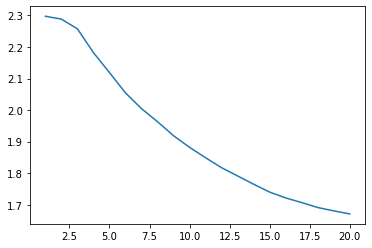

In [29]:
EPOCHS = 20
scores = []
for epoch in range(1, EPOCHS + 1):
  train_an_epoch(seq2seq, DATALOADERS_DICT['train_data'], OPTIMIZER, OPTIMIZER2, LOSS_FN, LOG_INTERVAL)
  if SINGLE_RECORD:
    validation_score = get_score(seq2seq, DATALOADERS_DICT['train_data'], LOSS_FN)
  else:
    validation_score = get_score(seq2seq, DATALOADERS_DICT['train_data'], LOSS_FN)
  scores.append(validation_score)

plt.plot(range(1, EPOCHS+1), scores)

## Generation

In [30]:
def generate(encoder, decoder, text, batch_size, method='sample'):
    start_token = torch.LongTensor([VOCAB.stoi['<sos>']])
    current_token = torch.cat((start_token, torch.zeros(BATCH_SIZE - 1))).int().unsqueeze(1)
    print(current_token)
    t = 0
    words = []
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        enc_out, hidden0 = encoder(text)

        while (t < MAX_SUMMARY_LENGTH) and (torch.sum(current_token) != VOCAB.stoi['<eos>']):
            # Depending on if working with a single record or not may need to change this
            word = current_token #.unsqueeze(1)
            d_out, d_hid = decoder(word, hidden0)
            if method=='sample':
                i = 0
                s = np.random.random()
                while s >= 0:
                    i += 1
                    s -= d_out[:, i][0]
                    
                words.append(VOCAB.itos[i])

            else:
                words.append(VOCAB.itos[d_out[0].argmax(0)])
            current_token = torch.cat((d_out[0].argmax(0).unsqueeze(0), torch.zeros(batch_size - 1))).int().unsqueeze(1)
            hidden0 = [x.detach() for x in d_hid]
            t+= 1
    return words

In [31]:
generate(encoder, decoder, f, BATCH_SIZE, 'nH')

tensor([[3]], dtype=torch.int32)


['make', 'drugs', 'legal', '<eos>']